# Настройки/Импорты

In [1]:
import numpy as np # для работы с массивами
import sys # для работы с системынми параметрами

import pandas as pd # для работы с DataFrame (сохранения файлов)

import time # для отслеживания времени выполнения
from tqdm import tqdm # для отслеживания прогресса
from matplotlib import pyplot as plt # для построения графиков/вывода изображений

In [2]:
RES_DIR = "./results/" # папка для сохранения результатов

N = np.arange(10, 501, 2) # число предметов в тест-кейсах (от 10 до 500 с шагом 2)
M = np.arange(1, 6, 1) # число тест-кейсов для определённого числа предметов (всего 5 различных запусков)
W = np.array([500, *np.arange(1000, 10001, 1000)]) # вместимость рюкзака (считаем, что каждое ограничение лимитированно значением W, иначе можно было бы просто сделать масштабирование данных до этих значений)
# W = np.array([500, 1000, 2000]) # вместимость рюкзака (считаем, что каждое ограничение лимитированно значением W, иначе можно было бы просто сделать масштабирование данных до этих значений)
# W = np.array([500]) # вместимость рюкзака (считаем, что каждое ограничение лимитированно значением W, иначе можно было бы просто сделать масштабирование данных до этих значений)
RANDOM_STATE = 42 # число для задания случайности
MAX_TIME = 60 # максимальное время выданное алгоритму в секундах на решение одного тест-кейса (если превысит — прерываем дальнейший подсчёт)

COLORS = {"Greedy algorithm": "k", "FPTAS": "y", "Dynamic programming": "b", "Branch-and-Bound": "r", "Meet-in-the-middle": "g", "Complete search": "m"} # цвета для графиков алгоритмов

In [ ]:
sys.setrecursionlimit(11000) # лимит на глубину рекурсии

# Вспомогательные функции

In [3]:
def sort_items(prices: np.array, weights: np.array) -> tuple:
    """
    Функция для сортировки списков стоимости и веса по их отношению.\n
    Parameters:
        * prices: список стоимостей предметов
        * weights: список весов предметов\n
    Returns:
        * tuple: отсортированные списки p, w
    """
    unit_cost = prices / weights # удельная стоимость предметов
    comb = list(zip(prices, weights, unit_cost)) # объединяем три списка в один список, из-за чего получаются кортежи 'price i, weight i, unit cost i'
    comb = sorted(comb, key=lambda x: -x[2]) # сортируем по значениям третьего списка - удельной стоимости (unit cost i)
    prices_sorted, weights_sorted, unit_cost_sorted = zip(*comb) # пересобираем zip (при этом транспонируя его обратно в формат 'prices list, weights list, unit_cost list')
    return np.array(prices_sorted), np.array(weights_sorted) # конвертируем в np.array и возвращаем отсортированные стоимости и веса

In [4]:
prices = np.array([50,60,100])
weights = np.array([1,2,3])
sort_items(prices, weights)

(array([ 50, 100,  60]), array([1, 3, 2]))

# Генерация тест-кейсов

* Число рассматриваемых предметов для помещения в рюкзак варьируется от 10 до 25. 
* Вещи отсортированы по удельной стоимости $\frac{price_i}{weight_i}$.

In [163]:
data = {} # словарь под сгенерированные данные

for n in N: # идём по числу предметов для рюкзака
    data[n] = {} # подсловарь под тест-кейсы 
    for test_case in M: # идём по номеру тест-кейса
        data[n][test_case] = {} # подсловарь под данные для задачи

        prices = np.random.RandomState(RANDOM_STATE + test_case).randint(low=1, high=100, size=n) # генерируем цены предметов из равномерного распределения [low, high) при фиксированном RandomState (зависящем от номера тест-кейса)
        weights = np.random.RandomState(RANDOM_STATE - test_case).randint(low=1, high=100, size=(n, )) # генерируем веса предметов из равномерного распределения [low, high) при фиксированном RandomState (зависящем от номера тест-кейса)
        prices_sorted, weights_sorted = sort_items(prices, weights) # сортируем предметы по удельной стоимости
        
        data[n][test_case]["Prices"] = prices_sorted # запоминаем данные для тест-кейса
        data[n][test_case]["Weights"] = weights_sorted # запоминаем данные для тест-кейса

data[10][1] # пример получившихся данных

{'Prices': array([50, 92, 65, 69, 18, 59, 60, 52, 17, 22]),
 'Weights': array([13, 27, 36, 65, 24, 81, 86, 90, 66, 99])}

# Реализация алгоритмов

## 1) Аппроксимации

### a) Greedy algorithm 

In [6]:
def greedy_alg(prices: np.array, weights: np.array, W) -> tuple:
    """
    Жадный алгоритм.\n
    Parameters:
        * prices: список стоимостей предметов (вещи отсортированы по удельной стоимости!)
        * weights: список весов предметов (вещи отсортированы по удельной стоимости!)
        * W: лимит рюкзака на вес\n
    Returns:
        * tuple: оптимальная цена рюкзака и array с указанием, какие предметы взяты или нет (1 - взяли в рюкзак, 0 - нет)
    """
    n = prices.shape[0] # число предметов

    P_opt = 0 # стоимость лучшего найденного рюкзака 
    I_opt = np.zeros(shape=(n,)) # список предметов, где индекс - номер предмета в множестве I (1 - взяли в рюкзак, 0 - нет)

    W_curr = 0 # текущий вес рюкзака
    for i in range(n): # идём по числу предметов
        if W_curr + weights[i] <= W: # если предмет влазит в рюкзак
            I_opt[i] = 1 # добавляем его
            W_curr += weights[i] # обновляем текущий вес рюкзака
            P_opt += prices[i] # обновляем текущую стоимость рюкзака
    return P_opt, I_opt # возвращаем стоимость лучшего найденного рюкзака и предметы

In [7]:
def greedy_alg_continuous(prices: np.array, weights: np.array, W) -> tuple:
    """
    Непрерывный вариант жадного алгоритма. Нужен для подсчёта верхней границы в Branch-and-Bound алгоритме.\n
    Parameters:
        * prices: список стоимостей предметов
        * weights: список весов предметов
        * W: лимит рюкзака на вес\n
    Returns:
        * tuple: оптимальная цена рюкзака и array с указанием, какие предметы взяты или нет (1 - взяли в рюкзак, 0 - нет)
    """
    n = prices.shape[0] # число предметов
    
    P_opt = 0 # стоимость лучшего найденного рюкзака 
    I_opt = np.zeros(shape=(n,)) # список предметов, где индекс - номер предмета в множестве I (1 - взяли в рюкзак, 0 - нет)

    W_curr = 0 # текущий вес рюкзака
    i = 0 # номер рассматриваемого предмета
    while W_curr < W and i < n: # пока есть место в рюкзаке и не все предметы рассмотрены
        piece = min((W - W_curr)/weights[i], 1) # считаем, какую часть предмета можем добавить в рюкзак (1 - если он полностью умещается)
        I_opt[i] = piece # добавляем эту часть
        W_curr += weights[i] * piece # обновляем текущий вес рюкзака
        P_opt += prices[i] * piece # обновляем текущую стоимость рюкзака
        i += 1 # переходим к следующему предмету
        
    return P_opt, I_opt # возвращаем стоимость лучшего найденного рюкзака и предметы

In [8]:
greedy_alg(data[20][2]["Prices"], data[20][2]["Weights"], W[0]) # пример работы алгоритма

(705,
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0.]))

In [9]:
greedy_alg_continuous(data[20][2]["Prices"], data[20][2]["Weights"], W[0]) # пример работы алгоритма

(725.7142857142857,
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.85714286,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]))

### b) Fully polynomial time approximation scheme (FPTAS)

In [10]:
def fptas(prices: np.array, weights: np.array, W, ε: np.float32) -> tuple:
    """
    Fully polynomial time approximation scheme (FPTAS) относительно стоимости рюкзака.\n
    Parameters:
        * prices: список стоимостей предметов
        * weights: список весов предметов
        * W: лимит рюкзака на вес
        * ε: параметр близости к оптимальному ответу (0, 1]\n
    Returns:
        * tuple: оптимальная цена рюкзака и array с указанием, какие предметы взяты или нет (1 - взяли в рюкзак, 0 - нет)
    """
    n = prices.shape[0] # число предметов
    price_max = prices.max() # максимальное значение среди цен
    k = ε * price_max / n # коэффициент скалирования цен предметов

    prices = np.array([0, *(prices/k).astype(np.int32)]) # добавляем фиктивный элемент на нулевой индекс, чтобы не приходилось делать смещение в цикле из-за нумерации предметов с нуля и скалируем на значение k с округлением вниз
    weights = np.array([0, *weights]) # добавляем фиктивный элемент на нулевой индекс, чтобы не приходилось делать смещение в цикле из-за нумерации предметов с нуля
    P = prices.sum() # максимальная стоимость рюкзака, что можно получить

    m = np.full(shape=(n+1, P+1), fill_value=W+1) # массив для решений динамического программирования (+1 для строки под предмет с максимальным номером и для столбца под стоимость P) изначально заполнен недопустимыми весами
    inclusion = np.full(shape=(n+1, P+1), fill_value=False) # матрица этапов добавления предмета в рюкзак, заполнена False, True будет ставиться при добавлении предмета в рюкзак
    m[0][0] = 0 # нулевое значение
    for i in range(1, n+1): # идём по индексам предметов (они с нуля в prices и weights, но с 1 в m)
        for p in range(0, P+1): # идём по возможным значениям стоимости рюкзака
            if prices[i] > p: # если стоимость рассматриваемого предмета i больше допустимой в рюкзаке на момент p
                m[i][p] = m[i-1][p] # дублируем в неё вес рюкзака без этого предмета
            #=========================== без запоминания предметов =========================
            # else: # если предмет подходит по допустимой стоимости
            #     m[i][p] = min(m[i-1][p], m[i-1][p-prices[i]] + weights[i]) # ищем минимальный вес для цены p если есть возможность взять предмет i
            #--------------------------- с запоминанием предметов --------------------------
            elif m[i-1][p] <= m[i-1][p-prices[i]] + weights[i]: # если не выгодно добавлять предмет i в рюкзак
                m[i][p] = m[i-1][p] # оставляем вес как без i-го предмета
            else: # если выгодно добавлять предмет i в рюкзак
                m[i][p] = m[i-1][p-prices[i]] + weights[i] # обновляем стоимость
                inclusion[i][p] = True # ставим флаг, что предмет i был добавлен при рассмотрении стоимости p
            #===============================================================================

    # считаем оптимальную стоимость рюкзака
    P_opt = 0 # оптимальная цена рюкзака, найденная алгоритмом
    for p in range(0, P+1): # идём по возможным значениям стоимости рюкзака
        if m[n,p] < W: # если данный рюкзак возможно собрать когда доступны все n предметов
            P_opt = p # запоминаем его стоимость

    # проходим обратно с поиском предметов, что были добавлены
    I_opt = np.zeros(shape=(n,)) # список предметов, где индекс - номер предмета в множестве I (1 - взяли в рюкзак, 0 - нет)
    i, p = n, P_opt # для итерации с конца
    while i > 0 and p > 0: # пока не закончились предметы или вес в рюкзаке
        if inclusion[i][p]: # если предмет был добавлен
            I_opt[i-1] = 1 # ставим метку, что предмет в рюкзаке (-1 из-за нумерации с нуля в списке предметов)
            p = p - prices[i] # уменьшаем стоимость рюкзака
        i = i - 1 # переходим к следующему (предыдущему) предмету

    return P_opt * k, I_opt # возвращаем стоимость лучшего найденного рюкзака (домноженную на коэффициент скалирования, чтобы вернуться к изначальным стоимостям) и предметы

In [11]:
fptas(data[20][2]["Prices"], data[20][2]["Weights"], W[0], 0.1) # пример работы алгоритма

(702.2800000000001,
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0.]))

## 2) Точные алгоритмы

### a) Dynamic programming

In [12]:
def dynamic_programming(prices: np.array, weights: np.array, W) -> tuple:
    """
    Алгоритм динамического программирования относительно веса рюкзака.\n
    Parameters:
        * prices: список стоимостей предметов
        * weights: список весов предметов
        * W: лимит рюкзака на вес\n
    Returns:
        * tuple: оптимальная цена рюкзака и array с указанием, какие предметы взяты или нет (1 - взяли в рюкзак, 0 - нет)
    """
    n = prices.shape[0] # число предметов

    prices = np.array([0, *prices]) # добавляем фиктивный элемент на нулевой индекс, чтобы не приходилось делать смещение в цикле из-за нумерации предметов с нуля
    weights = np.array([0, *weights]) # добавляем фиктивный элемент на нулевой индекс, чтобы не приходилось делать смещение в цикле из-за нумерации предметов с нуля

    m = np.zeros(shape=(n+1, W+1)) # массив для решений динамического программирования (+1 для строки под предмет с максимальным номером и для столбца под вес W)
    inclusion = np.full(shape=(n+1, W+1), fill_value=False) # матрица этапов добавления предмета в рюкзак, заполнена False, True будет ставиться при добавлении предмета в рюкзак
    for i in range(1, n+1): # идём по индексам предметов (они с нуля в prices и weights, но с 1 в m)
        for w in range(0, W+1): # идём по возможным значениям веса
            if weights[i] > w: # если вес рассматриваемого предмета i больше допустимого в рюкзаке на момент w
                m[i][w] = m[i-1][w] # дублируем в неё прибыльность рюкзака без этого предмета
            #=========================== без запоминания предметов =========================
            # else: # если предмет влазит в рюкзак
            #     m[i][w] = max(m[i-1][w], m[i-1][w-weights[i]] + prices[i]) 
            #--------------------------- с запоминанием предметов --------------------------
            elif m[i-1][w] >= m[i-1][w-weights[i]] + prices[i]: # если не выгодно добавлять предмет i в рюкзак
                m[i][w] = m[i-1][w] # оставляем стоимость как без i-го предмета
            else: # если выгодно добавлять предмет i в рюкзак
                m[i][w] = m[i-1][w-weights[i]] + prices[i] # обновляем стоимость
                inclusion[i][w] = True # ставим флаг, что предмет i был добавлен при рассмотрении веса w
            #===============================================================================

    # проходим обратно с поиском предметов, что были добавлены
    I_opt = np.zeros(shape=(n,)) # список предметов, где индекс - номер предмета в множестве I (1 - взяли в рюкзак, 0 - нет)
    i, w = n, W # для итерации с конца
    while i > 0 and w > 0: # пока не закончились предметы или вес в рюкзаке
        if inclusion[i][w]: # если предмет был добавлен
            I_opt[i-1] = 1 # ставим метку, что предмет в рюкзаке (-1 из-за нумерации с нуля в списке предметов)
            w = w - weights[i] # уменьшаем доступный вес
        i = i - 1 # переходим к следующему (предыдущему) предмету

    return m[n][W], I_opt # возвращаем стоимость лучшего найденного рюкзака и предметы

In [13]:
dynamic_programming(data[20][2]["Prices"], data[20][2]["Weights"], W[0]) # пример работы алгоритма

(705.0,
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0.]))

### b) Branch-and-Bound

In [14]:
class BranchAndBound_DFS():
    def __init__(self, prices: np.array, weights: np.array, W) -> None: # инициализация модели для решения задачи
        """
        Конструктор для задачи.\n
        Parameters:
            * prices: список стоимостей предметов
            * weights: список весов предметов
            * W: лимит рюкзака на вес\n
        Returns:
            * None: создаёт модель для Branch-and-Bound алгоритма
        """
        self.n = prices.shape[0] # число предметов
        self.prices = prices # запоминаем стоимости предметов
        self.weights = weights # запоминаем веса предметов
        self.W = W # запоминаем 

        self.P_curr = 0 # стоимость рассматриваемого рюкзака
        self.W_curr = 0 # вес рассматриваемого рюкзака
        self.I_curr = [] # текущий список из предметов, где индекс - его номер (1 или 0 - взяли или нет)

        self.P_opt, self.I_opt = greedy_alg(prices, weights, W) # считаем изначальное лучшее решение с помощью жадной эвристики


    def initialize_bnb(self) -> tuple:
        """
        Функция для запуска рекурсии.\n
        Returns:
            * tuple: оптимальная цена рюкзака и array с указанием, какие предметы взяты или нет (1 - взяли в рюкзак, 0 - нет)
        """
        self.recursion(1) # вызываем рекурсию, добавляя первый (нулевой) предмет в рюкзак 
        self.I_curr.pop() # удаляем добавленный в рекурсии элемент
        self.P_curr -= self.prices[0] # уменьшаем стоимость рюкзака на значение, что добавилось в рекурсии (предмет под индексом curr_item_pos + 1)
        self.W_curr -= self.weights[0] # уменьшаем вес рюкзака на значение, что добавилось в рекурсии (предмет под индексом curr_item_pos + 1)

        self.recursion(0) # вызываем рекурсию, не добавляя первый (нулевой) предмет в рюкзак 
        self.I_curr.pop() # удаляем добавленный в рекурсии элемент

        return self.P_opt, np.array(self.I_opt) # возвращаем стоимость лучшего найденного рюкзака и предметы (в виде array) 

    def recursion(self, value: np.int8) -> None:
        """
        Рекурсивная функция.\n
        Parameters:
            * value: значение новой переменной (может быть либо нулём - если предмет не берём, либо 1)\n
        Returns:
            * None: рекурсивно выполняет поиск оптимального решения
        """
        self.I_curr.append(value) # добавляем значение в рюкзак
        curr_item_pos = len(self.I_curr) - 1 # какой предмет в данный момент рассматривается
        self.P_curr += self.prices[curr_item_pos] * value # увеличиваем стоимость рюкзака, если должны взять предмет, иначе она не изменится, так как value был бы 0
        self.W_curr += self.weights[curr_item_pos] * value # увеличиваем вес рюкзака, если должны взять предмет, иначе она не изменится, так как value был бы 0

        if self.W_curr > self.W: # если решение не допустимо по весу
            return # выходим из рекурсии (возвращаемся на уровень выше в DFS)
        
        if len(self.I_curr) == self.n: # проверяем, находимся ли мы в листе (все предметы зафиксированы на 0 или 1)
            if self.P_curr > self.P_opt: # если решение оказалось оптимальнее, чем текущее лучшее
                self.P_opt = self.P_curr # обновляем лучшую стоимость рюкзака
                self.I_opt = self.I_curr.copy() # обновляем лучший список предметов
        else: # если мы не дошли до листа (не все предметы зафиксированы на 0 или 1)
            upper_bound = self.P_curr + greedy_alg_continuous(self.prices[curr_item_pos+1:], self.weights[curr_item_pos+1:], self.W - self.W_curr)[0] # считаем верхнюю границу для ветки (к текущему добавляем решение непрерывной задачи, но в которую отправили только енезафиксированные вещи)
            if upper_bound < self.P_opt: # проверяем, есть ли смысл рассматривать ветку дальше
                return # выходим из рекурсии (возвращаемся на уровень выше в DFS)
            
            self.recursion(1) # запускаем итерацию рекурсивного поиска, где value=1 — берём следующий предмет
            self.I_curr.pop() # удаляем добавленный в рекурсии элемент
            self.P_curr -= self.prices[curr_item_pos + 1] # уменьшаем стоимость рюкзака на значение, что добавилось в рекурсии (предмет под индексом curr_item_pos + 1)
            self.W_curr -= self.weights[curr_item_pos + 1] # уменьшаем вес рюкзака на значение, что добавилось в рекурсии (предмет под индексом curr_item_pos + 1)

            self.recursion(0) # запускаем итерацию рекурсивного поиска, где value=0 — не берём следующий предмет
            self.I_curr.pop() # удаляем добавленный в рекурсии элемент
            # не делаем аналогичных вычитаний, так как предмет на самом деле не добавлялся к рюкзаку
        
        return # выходим из рекурсии (возвращаемся на уровень выше в DFS)

In [15]:
bnb = BranchAndBound_DFS(data[20][2]["Prices"], data[20][2]["Weights"], W[0]) # создаём объект для метода ветвей и границ
bnb.initialize_bnb() # пример работы алгоритма

(705,
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0.]))

### c) Meet-in-the-middle

In [16]:
def meet_in_the_middle(prices: np.array, weights: np.array, W) -> tuple:
    """
    Алгоритм Meet-in-the-middle.\n
    Parameters:
        * prices: список стоимостей предметов
        * weights: список весов предметов
        * W: лимит рюкзака на вес\n
    Returns:
        * tuple: оптимальная цена рюкзака и array с указанием, какие предметы взяты или нет (1 - взяли в рюкзак, 0 - нет)
    """
    n = prices.shape[0] # число предметов
    middle = n // 2 # индекс среднего элемента

    left_prices = prices[:middle] # список стоимостей предметов в левом массиве
    left_weights = weights[:middle] # список весов предметов в левом массиве
    right_prices = prices[middle:] # список стоимостей предметов в правом массиве
    right_weights = weights[middle:] # список весов предметов в правом массиве

    # полный перебор решений для левого массива
    left_combinations = [] # список под комбинации решений вида [цена рюкзака, вес, входящие элементы]
    left_subsets = 2**middle # число вариантов решения для левого массива
    for i in range(left_subsets): # идём по числу вариантов решения
        left_solution = [0, 0, np.zeros(shape=(middle,))] # список под рассматриваемое решение вида [цена рюкзака, вес, входящие элементы]
        for j in range(middle): # идём по числу предметов в левом массиве
            if (i >> j) & 1: # делаем побитовый сдвиг вправо на j элементов (i >> j) и если число получилось нечётное (& 1), значит берём j-й предмет в рюкзак (таким образом будут рассмотрены все варианты)
                left_solution[0] += left_prices[j] # увеличиваем стоимость рюкзака
                left_solution[1] += left_weights[j] # увеличиваем вес рюкзака
                left_solution[2][j] = 1 # ставим флаг, что j-й предмет взят
        if left_solution[1] <= W: # если решение допустимо по весу
            left_combinations.append(left_solution) # запоминаем решение
    left_combinations.sort(key=lambda x: x[1]) # сортируем решения по весу (x[1]) от меньшего к болльшему

    # оставим среди решений левого массива только такие, что как по весу, так и по цене либо лучше, либо хуже остальных
    i, max_i = 0, len(left_combinations) - 1 # i для итерации по решениям
    while i != max_i: # пока не останутся решения только с выозрастающими стоимостью и весом
        if left_combinations[i][0] >= left_combinations[i+1][0]: # если следующее решение имеет хуже стоимость (но при этом у него больший вес, так как решения уже отсортированы по весу)
            del left_combinations[i+1] # удаляем следующее решение
            max_i -= 1 # уменьшаем число решений левого массива
        else: # если следующий элемент и по стоимости и по весу лучше
            i += 1 # переходим к его рассмотрению, так как все до него хуже и по стоимости и по весу

    # полный перебор решений для правого массива
    right_combinations = [] # список под комбинации решений вида [цена рюкзака, вес, входящие элементы]
    right_subsets = 2**(n-middle) # число вариантов решения для правого массива
    for i in range(right_subsets): # идём по числу вариантов решения
        right_solution = [0, 0, np.zeros(shape=(n-middle,))] # список под рассматриваемое решение вида [цена рюкзака, вес, входящие элементы]
        for j in range(n-middle): # идём по числу предметов в правом массиве массиве
            if (i >> j) & 1: # делаем побитовый сдвиг вправо на j элементов (i >> j) и если число получилось нечётное (& 1), значит берём j-й предмет в рюкзак (таким образом будут рассмотрены все варианты)
                right_solution[0] += right_prices[j] # увеличиваем стоимость рюкзака
                right_solution[1] += right_weights[j] # увеличиваем вес рюкзака
                right_solution[2][j] = 1 # ставим флаг, что j-й предмет взят
        if right_solution[1] <= W: # если решение допустимо по весу
            right_combinations.append(right_solution) # запоминаем решение
    right_combinations.sort(key=lambda x: x[1]) # сортируем решения по весу (x[1]) от меньшего к болльшему

    # ищем лучшую комбинацию решений левого и правого массива
    best_solution = [0, 0, np.zeros(shape=(n))] # лучшая комбинация решений левого и правого массива
    i = 0 # индекс для итерации по решениям левого массива (умно подгоняется из-за отсортированных левого и правого массива решений по весу)
    for right_solution in right_combinations: # идём по решениям правого массива
        # ищем оптимальное решение из левой части
        if right_solution[1] + left_combinations[i][1] <= W: # если текущая комбинация левого и правого решения допустима
            while i < max_i: # пока не проверены все левые решения (i < max_i)
                if right_solution[1] + left_combinations[i+1][1] <= W: # если правое решение улучшается левым
                    i += 1 # перемходим к следующему решению в левом массиве (они отсортированы от меньшего к большему, поэтому итерируемся, пока не найдём оптимальный для решения из правого массива)
                else:
                    break # выходим из цикла while
        else: # если комбинации недопустимы - ищем допустимую (всегда есть решение с весом равным нулю)
            while right_solution[1] + left_combinations[i][1] > W: # пока не выполнится ограничение по весу комбинации решений
                i -= 1 # переходи к левому решению с меньшим весом
        
        if right_solution[0] + left_combinations[i][0] > best_solution[0]: # если комбинация левого и правого решения оказалась лучшей
            best_solution[0] = right_solution[0] + left_combinations[i][0] # запоминаем их стоимость
            best_solution[1] = right_solution[1] + left_combinations[i][1] # запоминаем их вес
            best_solution[2] = np.concatenate((left_combinations[i][2], right_solution[2])) # запоминаем их предметы

    return best_solution[0], best_solution[2] # возвращаем стоимость лучшего найденного рюкзака и предметы

In [17]:
meet_in_the_middle(data[20][2]["Prices"], data[20][2]["Weights"], W[0]) # пример работы алгоритма

(705,
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0.]))

### d) Complete search

In [18]:
def complete_search(prices: np.array, weights: np.array, W) -> tuple:
    """
    Алгоритм полного перебора.\n
    Parameters:
        * prices: список стоимостей предметов
        * weights: список весов предметов
        * W: лимит рюкзака на вес\n
    Returns:
        * tuple: оптимальная цена рюкзака и array с указанием, какие предметы взяты или нет (1 - взяли в рюкзак, 0 - нет)
    """
    n = prices.shape[0] # число предметов
    subsets = 2**n # число вариантов

    P_opt = 0 # стоимость лучшего найденного рюкзака 
    for i in range(subsets): # идём по числу вариантов решения
        subset_P = 0 # стоимость предметов рассматриваемого решения
        subset_W = 0 # веса предметов рассматриваемого решения
        for j in range(n): # идём по числу предметов
            if (i >> j) & 1: # делаем побитовый сдвиг вправо на j элементов (i >> j) и если число получилось нечётное (& 1), значит берём j-й предмет в рюкзак (таким образом будут рассмотрены все варианты)
                subset_P += prices[j] # добавляем стоимость предмета j рюкзаку
                subset_W += weights[j] # добавляем вес предмета j рюкзаку

        if subset_W <= W and subset_P > P_opt: # если решение допустимо и лучше оптимального
            P_opt = subset_P # обновляем лучшую стоимость
            
            items_opt = np.zeros(shape=(n,)) # список предметов, где индекс - номер предмета в множестве I (1 - взяли в рюкзак, 0 - нет)
            for j in range(n): # идём по числу предметов
                if (i >> j) & 1: # делаем побитовый сдвиг вправо на j элементов (i >> j) и если число получилось нечётное (& 1), значит берём j-й предмет в рюкзак (таким образом будут рассмотрены все варианты)
                    items_opt[j] = 1 # запоминаем, какие предметы были в лучшем рюкзаке

    return P_opt, items_opt

In [19]:
complete_search(data[20][2]["Prices"], data[20][2]["Weights"], W[0]) # пример работы алгоритма

(705,
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0.]))

# Сравнение эффективности

In [215]:
def calc_time(alg: list, data: dict, W: list) -> dict:
    """
    Функция для подсчёта времени работы алгоритмов.\n
    Parameters:
        * alg: название рассматриваемого алгоритма
        * data: словарь с данными для тест-кейсов вида {число предметоав: {тест-кейсы: {"Prices": np.array, "Weights": np.array}}}
        * W: список рассматриваемых значений ограничений\n
    Returns:
        * dict: оптимальная цена рюкзака и array с указанием, какие предметы взяты или нет (1 - взяли в рюкзак, 0 - нет)
    """
    average_time = {} # словарь под среднее время работы при определённом значении n (число предметов)
    for n in tqdm(data.keys()): # идём по числу предметов для рюкзака
        average_time[n] = {} # подсловарь под среднее время при определённом значении W (число предметов)
        for w in W: # идём по вместимости рюкзака
            average_time[n][w] = 0 # поле под среднее время

            for test_case in data[n].keys(): # идём по номеру тест-кейса
                prices = data[n][test_case]["Prices"] # стоимости предметов в тест-кейсе
                weights = data[n][test_case]["Weights"] # веса предметов в тест-кейсе

                time_start = time.time() # замеряем время старта
                if alg == "Greedy algorithm":
                    greedy_alg(prices, weights, w) # запускаем алгоритм
                elif alg == "FPTAS":
                    fptas(prices, weights, w, 0.1) # запускаем алгоритм
                elif alg == "Dynamic programming":
                    dynamic_programming(prices, weights, w) # запускаем алгоритм
                elif alg == "Branch-and-Bound":
                    bnb = BranchAndBound_DFS(prices, weights, w) # создаём объект для метода ветвей и границ
                    bnb.initialize_bnb() # запускаем алгоритм
                elif alg == "Branch-and-Bound unopt":
                    bnb = BranchAndBound_DFS_unopt(prices, weights, w) # создаём объект для метода ветвей и границ
                    bnb.initialize_bnb() # запускаем алгоритм
                elif alg == "Meet-in-the-middle":
                    meet_in_the_middle(prices, weights, w) # запускаем алгоритм
                elif alg == "Complete search":
                    complete_search(prices, weights, w) # запускаем алгоритм
            
                time_end = time.time() - time_start # считаем время работы алгоритма
                average_time[n][w] += time_end # добавляем время, затраченное алгоритмом на решение тест-кейса при числе предметов n и вместимостью рюкзака w

            average_time[n][w] = average_time[n][w]/len(M) # усредняем время по числу тест-кейсов
            if average_time[n][w] > MAX_TIME: # если среднее время работы алгоритма alg превысило допустимое
                print(f"Алгоритм '{alg}' не уложился по времени при решении задач с размерностью {n} и вместимостью рюкзака {w}!")
                return average_time
    return average_time

In [ ]:
algs = ["Greedy algorithm", "FPTAS", "Dynamic programming", "Branch-and-Bound", "Meet-in-the-middle", "Complete search"] # список названия алгоритмов для проверки
for alg in algs: # идём по рассматриваемым алгоритмам 
    print(f"Рассматривается алгоритм '{alg}'!")
    working_time = calc_time(alg, data, W) # считаем время работы алгоритма
    pd.DataFrame(working_time).to_csv(f"{RES_DIR}time_{alg}.csv") # сохраняем в формате csv

### *) Тестирование Branch-and-Bound без начального решения и отсортированных предметов

In [ ]:
def greedy_alg_continuous_unsort(prices: np.array, weights: np.array, W) -> tuple:
    """
    Непрерывный вариант жадного алгоритма. Нужен для подсчёта верхней границы в Branch-and-Bound алгоритме.\n
    Parameters:
        * prices: список стоимостей предметов
        * weights: список весов предметов
        * W: лимит рюкзака на вес\n
    Returns:
        * tuple: оптимальная цена рюкзака и array с указанием, какие предметы взяты или нет (1 - взяли в рюкзак, 0 - нет)
    """
    prices, weights = sort_items(prices, weights) # сортируем предметы по удельной стоимости
    
    n = prices.shape[0] # число предметов
    
    P_opt = 0 # стоимость лучшего найденного рюкзака 
    I_opt = np.zeros(shape=(n,)) # список предметов, где индекс - номер предмета в множестве I (1 - взяли в рюкзак, 0 - нет)

    W_curr = 0 # текущий вес рюкзака
    i = 0 # номер рассматриваемого предмета
    while W_curr < W and i < n: # пока есть место в рюкзаке и не все предметы рассмотрены
        piece = min((W - W_curr)/weights[i], 1) # считаем, какую часть предмета можем добавить в рюкзак (1 - если он полностью умещается)
        I_opt[i] = piece # добавляем эту часть
        W_curr += weights[i] * piece # обновляем текущий вес рюкзака
        P_opt += prices[i] * piece # обновляем текущую стоимость рюкзака
        i += 1 # переходим к следующему предмету
        
    return P_opt, I_opt # возвращаем стоимость лучшего найденного рюкзака и предметы

In [ ]:
class BranchAndBound_DFS_unopt():
    def __init__(self, prices: np.array, weights: np.array, W) -> None: # инициализация модели для решения задачи
        """
        Конструктор для задачи.\n
        Parameters:
            * prices: список стоимостей предметов
            * weights: список весов предметов
            * W: лимит рюкзака на вес\n
        Returns:
            * None: создаёт модель для Branch-and-Bound алгоритма
        """
        self.n = prices.shape[0] # число предметов
        self.prices = prices # запоминаем стоимости предметов
        self.weights = weights # запоминаем веса предметов
        self.W = W # запоминаем 

        self.P_curr = 0 # стоимость рассматриваемого рюкзака
        self.W_curr = 0 # вес рассматриваемого рюкзака
        self.I_curr = [] # текущий список из предметов, где индекс - его номер (1 или 0 - взяли или нет)

        self.P_opt, self.I_opt = 0, [] # начального решения нет


    def initialize_bnb(self) -> tuple:
        """
        Функция для запуска рекурсии.\n
        Returns:
            * tuple: оптимальная цена рюкзака и array с указанием, какие предметы взяты или нет (1 - взяли в рюкзак, 0 - нет)
        """
        self.recursion(1) # вызываем рекурсию, добавляя первый (нулевой) предмет в рюкзак 
        self.I_curr.pop() # удаляем добавленный в рекурсии элемент
        self.P_curr -= self.prices[0] # уменьшаем стоимость рюкзака на значение, что добавилось в рекурсии (предмет под индексом curr_item_pos + 1)
        self.W_curr -= self.weights[0] # уменьшаем вес рюкзака на значение, что добавилось в рекурсии (предмет под индексом curr_item_pos + 1)

        self.recursion(0) # вызываем рекурсию, не добавляя первый (нулевой) предмет в рюкзак 
        self.I_curr.pop() # удаляем добавленный в рекурсии элемент

        return self.P_opt, np.array(self.I_opt) # возвращаем стоимость лучшего найденного рюкзака и предметы (в виде array) 

    def recursion(self, value: np.int8) -> None:
        """
        Рекурсивная функция.\n
        Parameters:
            * value: значение новой переменной (может быть либо нулём - если предмет не берём, либо 1)\n
        Returns:
            * None: рекурсивно выполняет поиск оптимального решения
        """
        self.I_curr.append(value) # добавляем значение в рюкзак
        curr_item_pos = len(self.I_curr) - 1 # какой предмет в данный момент рассматривается
        self.P_curr += self.prices[curr_item_pos] * value # увеличиваем стоимость рюкзака, если должны взять предмет, иначе она не изменится, так как value был бы 0
        self.W_curr += self.weights[curr_item_pos] * value # увеличиваем вес рюкзака, если должны взять предмет, иначе она не изменится, так как value был бы 0
        # print(f"{curr_item_pos} P_curr: {self.P_curr}, W_curr: {self.W_curr}, i_curr: {self.I_curr}")

        if self.W_curr > self.W: # если решение не допустимо по весу
            # print(f"{curr_item_pos} Weight!")
            return # выходим из рекурсии (возвращаемся на уровень выше в DFS)
        
        if len(self.I_curr) == self.n: # проверяем, находимся ли мы в листе (все предметы зафиксированы на 0 или 1)
            # print(f"{curr_item_pos} Leaf!")
            if self.P_curr > self.P_opt: # если решение оказалось оптимальнее, чем текущее лучшее
                # print(f"{curr_item_pos} New opt!")
                self.P_opt = self.P_curr # обновляем лучшую стоимость рюкзака
                self.I_opt = self.I_curr.copy() # обновляем лучший список предметов
        else: # если мы не дошли до листа (не все предметы зафиксированы на 0 или 1)
            upper_bound = self.P_curr + greedy_alg_continuous_unsort(self.prices[curr_item_pos+1:], self.weights[curr_item_pos+1:], self.W - self.W_curr)[0] # считаем верхнюю границу для ветки (к текущему добавляем решение непрерывной задачи, но в которую отправили только енезафиксированные вещи)
            if upper_bound < self.P_opt: # проверяем, есть ли смысл рассматривать ветку дальше
                # print(f"{curr_item_pos} Upper Bound!")
                return # выходим из рекурсии (возвращаемся на уровень выше в DFS)
            
            # print(f"{curr_item_pos} R1!")
            self.recursion(1) # запускаем итерацию рекурсивного поиска, где value=1 — берём следующий предмет
            self.I_curr.pop() # удаляем добавленный в рекурсии элемент
            self.P_curr -= self.prices[curr_item_pos + 1] # уменьшаем стоимость рюкзака на значение, что добавилось в рекурсии (предмет под индексом curr_item_pos + 1)
            self.W_curr -= self.weights[curr_item_pos + 1] # уменьшаем вес рюкзака на значение, что добавилось в рекурсии (предмет под индексом curr_item_pos + 1)

            # print(f"{curr_item_pos} R0!")
            self.recursion(0) # запускаем итерацию рекурсивного поиска, где value=0 — не берём следующий предмет
            self.I_curr.pop() # удаляем добавленный в рекурсии элемент
            # не делаем аналогичных вычитаний, так как предмет на самом деле не добавлялся к рюкзаку
        
        return # выходим из рекурсии (возвращаемся на уровень выше в DFS)

In [216]:
data_unsorted = {} # словарь под сгенерированные данные

for n in N: # идём по числу предметов для рюкзака
    data_unsorted[n] = {} # подсловарь под тест-кейсы 
    for test_case in M: # идём по номеру тест-кейса
        data_unsorted[n][test_case] = {} # подсловарь под данные для задачи

        data_unsorted[n][test_case]["Prices"] = np.random.RandomState(RANDOM_STATE + test_case).randint(low=1, high=100, size=n) # генерируем цены предметов из равномерного распределения [low, high) при фиксированном RandomState (зависящем от номера тест-кейса)
        data_unsorted[n][test_case]["Weights"] = np.random.RandomState(RANDOM_STATE - test_case).randint(low=1, high=100, size=(n, )) # генерируем веса предметов из равномерного распределения [low, high) при фиксированном RandomState (зависящем от номера тест-кейса)

data_unsorted[10][1] # пример получившихся данных

{'Prices': array([69, 65, 50, 22, 59, 17, 52, 18, 60, 92]),
 'Weights': array([65, 36, 13, 99, 81, 66, 90, 24, 86, 27])}

In [ ]:
bnb = BranchAndBound_DFS_unopt(data_unsorted[500][1]["Prices"], data_unsorted[500][1]["Weights"], 100) # создаём объект для метода ветвей и границ
bnb.initialize_bnb() # пример работы алгоритма

(1735,
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
bnb = BranchAndBound_DFS(data[500][1]["Prices"], data[500][1]["Weights"], 100) # создаём объект для метода ветвей и границ
bnb.initialize_bnb() # пример работы алгоритма

(1735,
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
     

In [219]:
algs = ["Branch-and-Bound unopt"] # список названия алгоритмов для проверки
for alg in algs: # идём по рассматриваемым алгоритмам 
    print(f"Рассматривается алгоритм '{alg}'!")
    working_time = calc_time(alg, data_unsorted, W) # считаем время работы алгоритма
    pd.DataFrame(working_time).to_csv(f"{RES_DIR}time_{alg}.csv") # сохраняем в формате csv

Рассматривается алгоритм 'Branch-and-Bound unopt'!


 52%|█████▏    | 129/246 [2:42:38<2:27:30, 75.65s/it] 

Алгоритм 'Branch-and-Bound unopt' не уложился по времени при решении задач с размерностью 268 и вместимостью рюкзака 500!


## Вывод времени решения всех алгоритмов вместе

In [222]:
average_times = {} # словарь под среднее время алгоритма
w = W[0] # рассматриваемая вместимость рюкзака (500)
algs = ["Greedy algorithm", "FPTAS", "Dynamic programming", "Branch-and-Bound", "Branch-and-Bound unopt", "Meet-in-the-middle", "Complete search"] # список названия алгоритмов для проверки
for alg in algs: # идём по рассматриваемым алгоритмам 
    average_times[alg] = pd.read_csv(f"{RES_DIR}time_{alg}.csv", sep=",", index_col=0).loc[w].values # загружаем среднее время для алгоритма при w и всех рассмотренных n

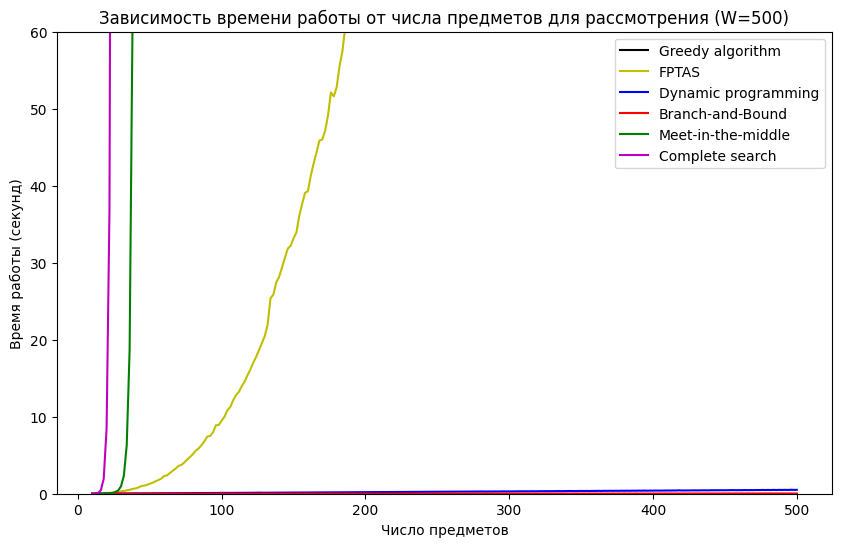

In [81]:
plt.figure(figsize=(10,6)) # задание размера фигуры

algs = ["Greedy algorithm", "FPTAS", "Dynamic programming", "Branch-and-Bound", "Meet-in-the-middle", "Complete search"] # список названия алгоритмов для проверки
w = W[0] # рассматриваемая вместимость рюкзака (500)
for alg in algs: # идём по рассматриваемым алгоритмам 
    plt.plot(N[:len(average_times[alg])], average_times[alg], color=COLORS[alg], label=alg) # строим график
plt.title(f"Зависимость времени работы от числа предметов для рассмотрения (W={w})") # название фигуры
plt.xlabel("Число предметов") # подпись по оси x
plt.ylabel("Время работы (секунд)") # подпись по оси y
plt.ylim([0, 60]) # ставим лимит по времени в секундах
plt.legend() # отображение подписей графиков
plt.show() # показ фигуры

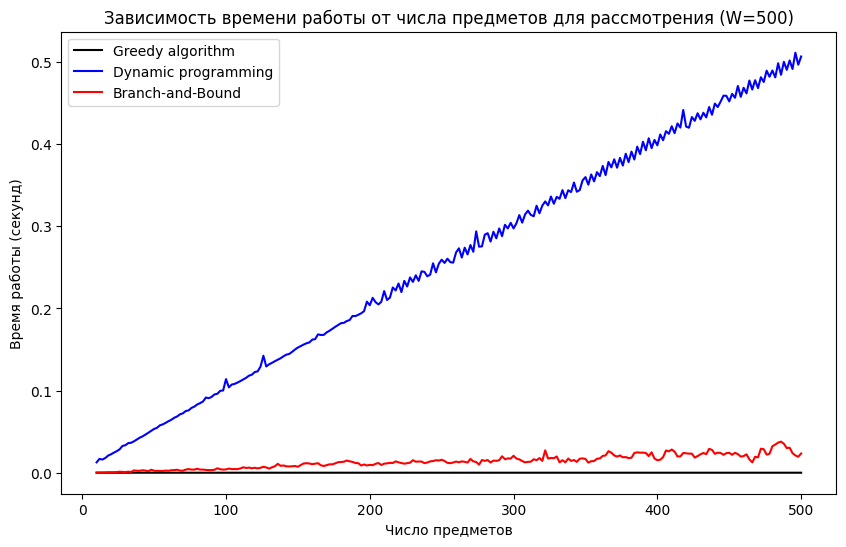

In [82]:
plt.figure(figsize=(10,6)) # задание размера фигуры

algs = ["Greedy algorithm", "Dynamic programming", "Branch-and-Bound"] # список названия алгоритмов для проверки
w = W[0] # рассматриваемая вместимость рюкзака (500)
for alg in algs: # идём по рассматриваемым алгоритмам 
    plt.plot(N[:len(average_times[alg])], average_times[alg], color=COLORS[alg], label=alg) # строим график
plt.title(f"Зависимость времени работы от числа предметов для рассмотрения (W={w})") # название фигуры
plt.xlabel("Число предметов") # подпись по оси x
plt.ylabel("Время работы (секунд)") # подпись по оси y
# plt.ylim([0, 60]) # ставим лимит по времени в секундах
plt.legend() # отображение подписей графиков
plt.show() # показ фигуры

## Вывод времени для каждого алгоритма

Графики для ожидаемого времени работы.

In [233]:
expected_time = {}
w = W[0]

algs = ["Greedy algorithm", "FPTAS", "Dynamic programming", "Branch-and-Bound", "Meet-in-the-middle", "Complete search"] # список названия алгоритмов для проверки
for alg in algs:
    if alg == "Greedy algorithm":
        expected_time[alg] = [0.00000001*x + 0.00025 for x in N[:len(average_times[alg])]]
    if alg == "FPTAS":
        expected_time[alg] = [0.0000013*(x**3 / 0.1) for x in N[:len(average_times[alg])]]
    if alg == "Dynamic programming":
        expected_time[alg] = [0.000002*x*w + 0.05 for x in N[:len(average_times[alg])]]
    if alg == "Branch-and-Bound":
        expected_time[alg] = [0.0000001 * (2**x) for x in N[:len(average_times[alg])]]
    if alg == "Meet-in-the-middle":
        expected_time[alg] = [0.000005 * x * (2**(x/2)) for x in N[:len(average_times[alg])]]
    if alg == "Complete search":
        expected_time[alg] = [0.000015 * (2**x) for x in N[:len(average_times[alg])]]

Сравнение с ожидаемым временем работы.

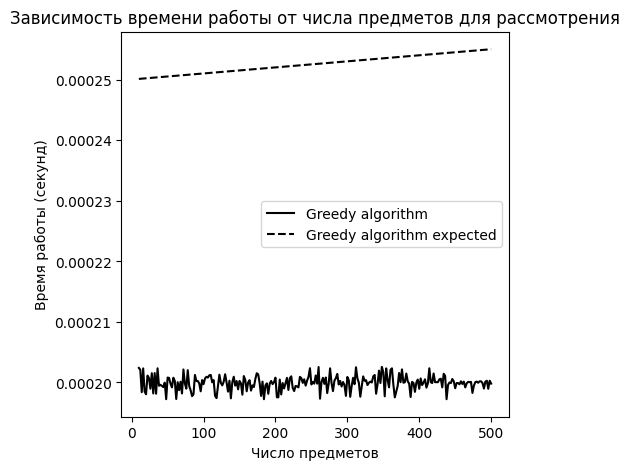

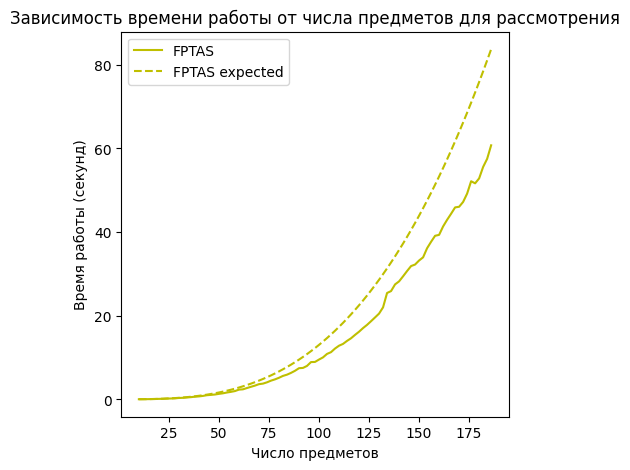

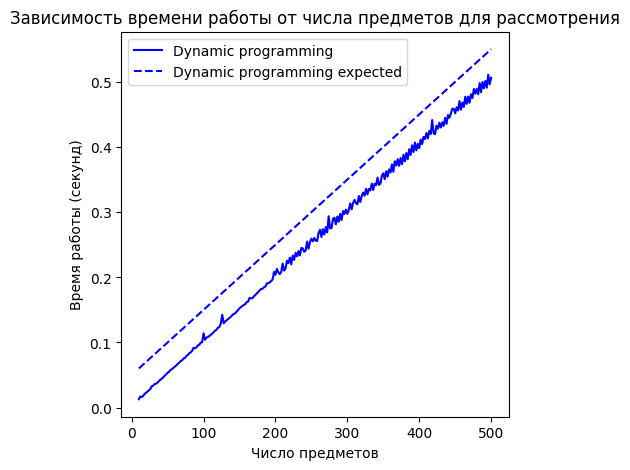

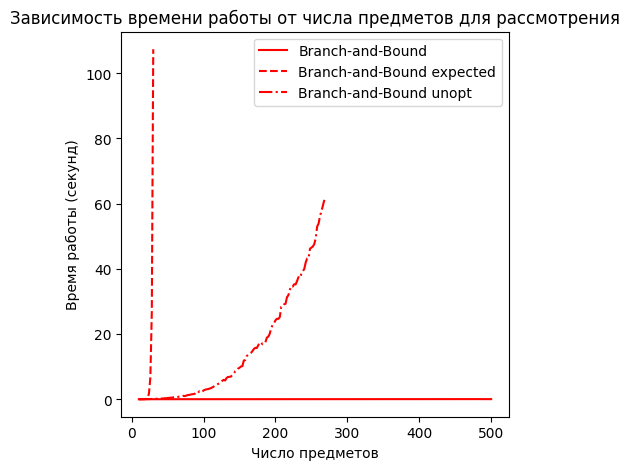

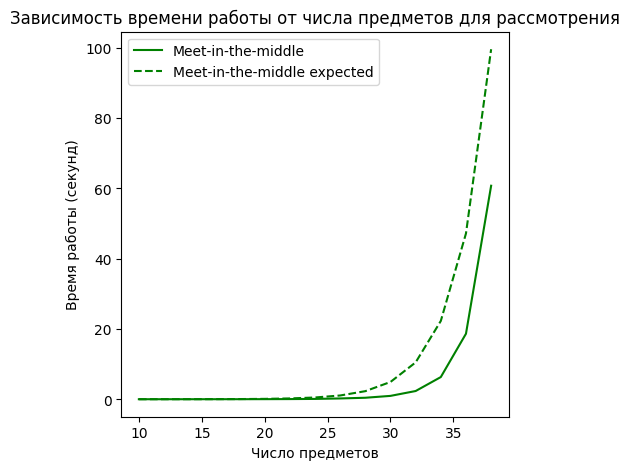

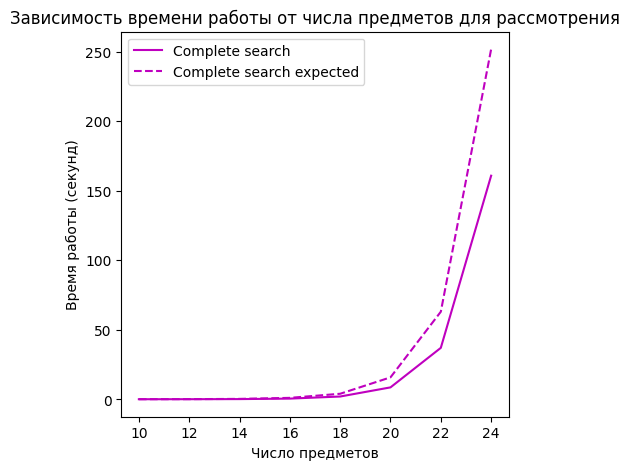

In [239]:
w = W[0] # рассматриваемая вместимость рюкзака (500)

algs = ["Greedy algorithm", "FPTAS", "Dynamic programming", "Branch-and-Bound", "Meet-in-the-middle", "Complete search"] # список названия алгоритмов для построения графиков
for alg in algs: # идём по названиям рассматриваемых алгоритмов
    plt.figure(figsize=(5,5)) # задание размера фигуры

    plt.plot(N[:len(average_times[alg])], average_times[alg], "-", color=COLORS[alg], label=alg) # строим график
    plt.plot(N[:len(expected_time[alg])], expected_time[alg], "--", color=COLORS[alg], label=f"{alg} expected") # строим график
    if alg == "Branch-and-Bound": # дополнительный график не оптимизированной версии
        plt.plot(N[:len(average_times["Branch-and-Bound unopt"])], average_times["Branch-and-Bound unopt"], "-.", color=COLORS[alg], label="Branch-and-Bound unopt") # строим график

    plt.title(f"Зависимость времени работы от числа предметов для рассмотрения") # название фигуры
    plt.xlabel("Число предметов") # подпись по оси x
    plt.ylabel("Время работы (секунд)") # подпись по оси y
    plt.legend() # отображение подписей графиков
    plt.show() # показ фигуры

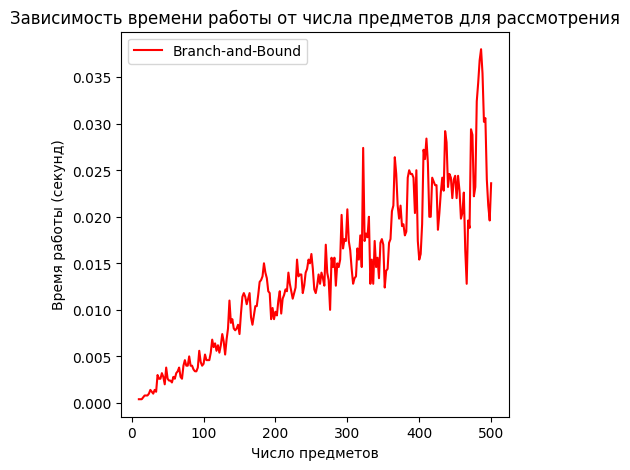

In [240]:
alg = "Branch-and-Bound" # название алгоритма
plt.figure(figsize=(5,5)) # задание размера фигуры
plt.plot(N[:len(average_times[alg])], average_times[alg], "-", color=COLORS[alg], label=alg) # строим график
plt.title(f"Зависимость времени работы от числа предметов для рассмотрения") # название фигуры
plt.xlabel("Число предметов") # подпись по оси x
plt.ylabel("Время работы (секунд)") # подпись по оси y
plt.legend() # отображение подписей графиков
plt.show() # показ фигуры

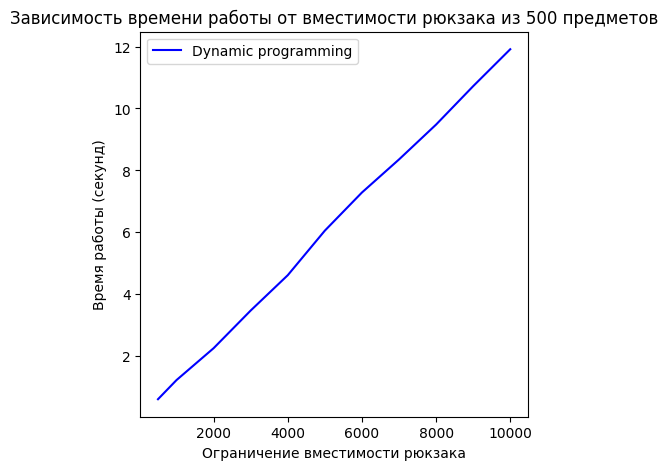

In [86]:
plt.figure(figsize=(5,5)) # задание размера фигуры

n = N[-1] # рассматриваемое число предметов (500)
alg = "Dynamic programming" # название алгоритма
for w in W: # идём по названиям рассматриваемых алгоритмов
    average_time = pd.read_csv(f"{RES_DIR}time_{alg}.csv", sep=",", index_col=0)["500"].values # берём столбец датасета с данными о запуске с числом предметов равным 500
plt.plot(W[:len(average_time)], average_time, color=COLORS[alg], label=alg) # строим график

plt.title(f"Зависимость времени работы от вместимости рюкзака из {n} предметов") # название фигуры
plt.xlabel("Ограничение вместимости рюкзака") # подпись по оси x
plt.ylabel("Время работы (секунд)") # подпись по оси y
plt.legend() # отображение подписей графиков
plt.show() # показ фигуры

# Стресс-тесты

In [30]:
data_hard = {} # словарь под сгенерированные данные
N_hard = np.arange(500, 10001, 100) # число предметов в стресс-кейсах (от 100 до 10000 с шагом 100)
W_hard = np.arange(10000, 100001, 10000) # вместимость рюкзака в стресс-кейсах (от 100 до 10000 с шагом 100)
M_hard = np.arange(1, 3, 1) # число стресс-кейсов для определённого числа предметов (всего 3 различных запусков)

for n in N_hard: # идём по числу предметов для рюкзака
    data_hard[n] = {} # подсловарь под тест-кейсы 
    for test_case in M_hard: # идём по номеру тест-кейса
        data_hard[n][test_case] = {} # подсловарь под данные для задачи

        prices = np.random.RandomState(RANDOM_STATE + test_case).randint(low=1, high=100, size=n) # генерируем цены предметов из равномерного распределения [low, high) при фиксированном RandomState (зависящем от номера тест-кейса)
        weights = np.random.RandomState(RANDOM_STATE - test_case).randint(low=1, high=100, size=(n, )) # генерируем веса предметов из равномерного распределения [low, high) при фиксированном RandomState (зависящем от номера тест-кейса)
        prices_sorted, weights_sorted = sort_items(prices, weights) # сортируем предметы по удельной стоимости
        
        data_hard[n][test_case]["Prices"] = prices_sorted # запоминаем данные для тест-кейса
        data_hard[n][test_case]["Weights"] = weights_sorted # запоминаем данные для тест-кейса

In [ ]:
algs_hard = ["Dynamic programming", "Branch-and-Bound"] # список названия алгоритмов для проверки
for alg in algs_hard:
    print(f"Рассматривается алгоритм '{alg}'!")
    working_time = calc_time(alg, data_hard, W_hard) # считаем время работы алгоритма
    pd.DataFrame(working_time).to_csv(f"{RES_DIR}time_hard_{alg}.csv")

In [92]:
average_times_hard = {} # словарь под среднее время алгоритма
algs = ["Dynamic programming", "Branch-and-Bound"] # список названия алгоритмов для проверки
for alg in algs: # идём по рассматриваемым алгоритмам 
    average_times_hard[alg] = pd.read_csv(f"{RES_DIR}time_{alg}.csv", sep=",", index_col=0) # загружаем среднее время для алгоритма при w и всех рассмотренных n

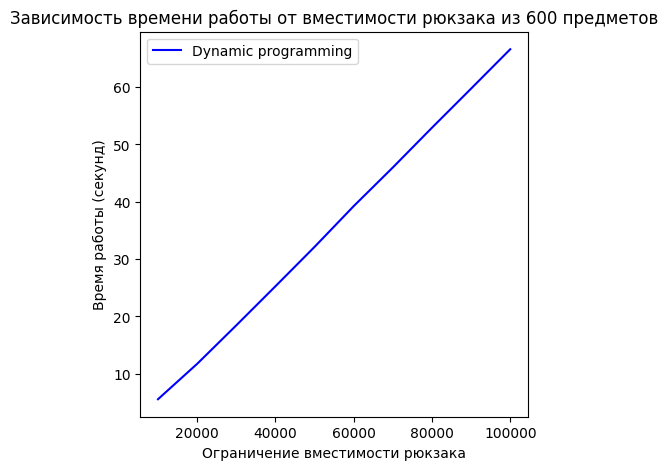

In [101]:
plt.figure(figsize=(5,5)) # задание размера фигуры

n = 600 # число рассматриваемых предметов
average_time = [] # список под среднее время алгоритма
# alg = "Branch-and-Bound" # название алгоритма
alg = "Dynamic programming" # название алгоритма
average_time = pd.read_csv(f"{RES_DIR}time_hard_{alg}.csv", sep=",", index_col=0)[f"{n}"].values # берём столбец датасета с данными о запуске с числом предметов равным 500
plt.plot(W_hard[:len(average_time)], average_time, color=COLORS[alg], label=alg) # строим график

plt.title(f"Зависимость времени работы от вместимости рюкзака из {n} предметов") # название фигуры
plt.xlabel("Ограничение вместимости рюкзака") # подпись по оси x
plt.ylabel("Время работы (секунд)") # подпись по оси y
plt.legend() # отображение подписей графиков
plt.show() # показ фигуры

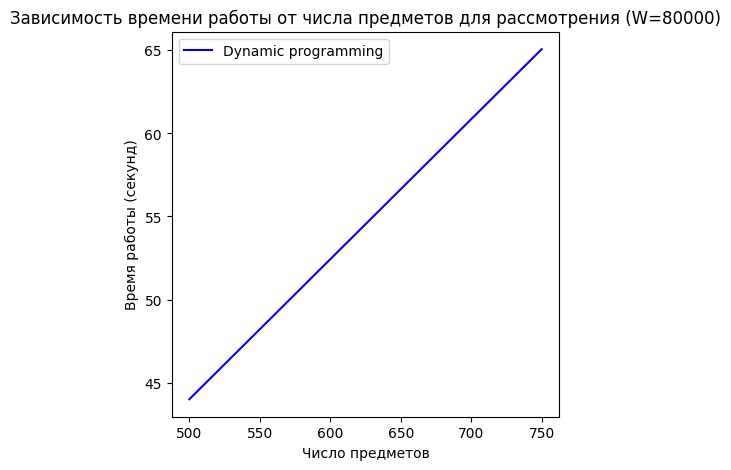

In [119]:
# plt.figure(figsize=(5,5)) # задание размера фигуры

# w = 80000 # рассматриваемая вместимость рюкзака (500)
# average_times = [] # список под среднее время алгоритма
# alg = "Dynamic programming" # название алгоритма
# for n in N_hard: # идём по числу предметов для рюкзака
#     if alg in average_times_hard[n][w].keys(): # если алгоритм справился с рассматриваемыми данными
#         average_times.append(average_times_hard[n][w][alg]) # добавляем среднее время при числе переменных n для алгоритма alg в общий список  
# plt.plot(N_hard[:len(average_times)], average_times, color=COLORS[alg], label=alg) # строим график

# plt.title(f"Зависимость времени работы от числа предметов для рассмотрения (W={w})") # название фигуры
# plt.xlabel("Число предметов") # подпись по оси x
# plt.ylabel("Время работы (секунд)") # подпись по оси y
# plt.legend() # отображение подписей графиков
# plt.show() # показ фигуры

# Проверка согласованности ответов

In [ ]:
for n in tqdm(N): # идём по числу предметов для рюкзака
    for test_case in M: # идём по номеру тест-кейса
        prices = data[n][test_case]["Prices"] # стоимости предметов в тест-кейсе
        weights = data[n][test_case]["Weights"] # веса предметов в тест-кейсе
        W = W[5] # ограничение вместимости рюкзака

        price = {} # словарь под решения (стоимость рюкзака), полученные алгоритмами
        items = {} # словарь под решения (вещи в рюкзаке), полученные алгоритмами

        # запускаем подсчёт алгоритмов
        price["Greedy algorithm"], items["Greedy algorithm"] = greedy_alg(prices, weights, W) # запускаем алгоритм

        price["FPTAS"], items["FPTAS"] = fptas(prices, weights, W, 0.1) # запускаем алгоритм

        price["Dynamic programming"], items["Dynamic programming"] = dynamic_programming(prices, weights, W) # запускаем алгоритм

        bnb = BranchAndBound_DFS(prices, weights, W) # создаём объект для метода ветвей и границ
        price["Branch-and-Bound"], items["Branch-and-Bound"] = bnb.initialize_bnb() # запускаем алгоритм

        price["Meet-in-the-middle"], items["Meet-in-the-middle"] = meet_in_the_middle(prices, weights, W) # запускаем алгоритм

        price["Complete search"], items["Complete search"] = complete_search(prices, weights, W) # запускаем алгоритм

        # проверка правильности решений
        for alg_1 in ["Dynamic programming", "Branch-and-Bound", "Meet-in-the-middle", "Complete search"]: # идём по названиям рассматриваемых алгоритмов
            for alg_2 in ["Dynamic programming", "Branch-and-Bound", "Meet-in-the-middle", "Complete search"]: # идём по названиям рассматриваемых алгоритмов
                # if not (price[alg_1] == price[alg_2] and (items[alg_1] == items[alg_2]).all()): # если не все ответы точных алгоритмов совпали, как по стоимости рюкзака, так и по его наполнению
                if price[alg_1] != price[alg_2]: # если ответы точных алгоритмов не совпали по стоимости рюкзака (вещи в них могут отличаться при равной цене)
                    raise Exception(f"Ответы точных алгоритмов {alg_1} и {alg_2} не сошлись при n={n} и тест-кейсе {test_case}!") # выкидываем исключение
        
        if not ((1-0.1)*price["Dynamic programming"] <= price["FPTAS"] <= price["Dynamic programming"]): # если FPTAS не показал заданную точность
            raise Exception("Ответ FPTAS не соответствует отклонению ε от оптимума.") # выкидываем исключение

100%|██████████| 11/11 [05:05<00:00, 27.78s/it]
